In [ ]:
!pip install deap
!pip install pandas
!pip install matplotlib
!pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
import operator
import math
import random
from deap import base, creator, gp
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

np.random.seed(42)

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print(f"Dataset shape: {train_data.shape}")
print(f"Columns: {train_data.columns.tolist()}")

# Here I print the missing values, just to have an idea of the dataset. Although kaggle has it on UI, but I preferred it this way!
print(f"Missing values:\n{train_data.isnull().sum()}")

print(f"\nFirst few rows:")
print(train_data.head())

Dataset shape: (39073, 15)
Columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
Missing values:
age                 0
workclass         769
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        771
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    222
income              0
dtype: int64

First few rows:
   age     workclass  fnlwgt  education  education-num      marital-status  \
0   37       Private  193106  Bachelors             13       Never-married   
1   56  Self-emp-inc  216636       12th              8  Married-civ-spouse   
2   53       Private  126977    HS-grad              9           Separated   
3   72       Private  205343       11th              7             Widowed

In [ ]:
# Created this function to remove the unnecessary features, or features with a ot of missing values. The columns were selected after manually going through the data.
def remove_unnecessary_features(df):
    """Remove columns that hurt more than help"""
    df_clean = df.copy()

    # fnlwgt: KAggle mentions that it is the final sampling weight, so didnt see much use for this.
    # education: Since we already have education-num, I found it redundant.
    # Native Country: This was interesting case actually, since 90% were USA, removing it was a gamble but it paid off with better accuracy! :)
    # PS: I tried removing capital-gain and capital-loss too, but the accuracy dropped significantly, so had to add them again! :(
    columns_to_remove = [
        'fnlwgt',
        'education',
        'native-country'
    ]

    # Safety CHeck
    existing_columns = [col for col in columns_to_remove if col in df_clean.columns]
    df_clean = df_clean.drop(columns=existing_columns)

    print(f"Removed columns: {existing_columns}")
    print(f"Remaining features: {df_clean.columns.tolist()}")

    return df_clean

# Here we process the numerical and categorical columns.
def preprocess_data(data):
    """Preprocess the Adult Income dataset"""
    df = data.copy()
    df = remove_unnecessary_features(df)

    # HAndle missing values (represented as '?' in the dataset)
    df = df.replace('?', np.nan)

    if 'income' in df.columns:
        y = df['income']
        df = df.drop('income', axis=1)
    else:
        y = None

    if 'id' in df.columns:
        ids = df['id']
        df = df.drop('id', axis=1)
    else:
        ids = None

    # Numerical features
    numerical_features = ['age', 'education-num', 'hours-per-week', 'capital-gain', 'capital-loss']

    # Categorical features
    categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

    # Running the model takes hours, just making sure no funny business happens with the processed dataset! :(
    for feature in numerical_features:
        if feature in df.columns:
            df[feature] = pd.to_numeric(df[feature], errors='coerce')  # Convert to numeric, coerce errors to NaN
            df[feature] = df[feature].fillna(df[feature].median())

    # Normalize numerical features
    scaler = StandardScaler()
    df[numerical_features] = scaler.fit_transform(df[numerical_features])

    # Last week in my intro to ML module, we were taught aabout data processing, so decided to set the drop_first to True, since it reduces the dimensions. This was experiment tbh, but turned out to be better! :)
    for feature in categorical_features:
        if feature in df.columns:
            df[feature] = df[feature].fillna('Unknown')

    df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

    return df, y, ids

In [ ]:
# Preprocess training and test data
X_train_processed, y_train_processed, _ = preprocess_data(train_data)
X_test_processed, _, test_ids = preprocess_data(test_data)

print("Training columns:", X_train_processed.columns[:10].tolist())
print("Test columns:", X_test_processed.columns[:10].tolist())

X_train, X_val, y_train, Y_val = train_test_split(
    X_train_processed, y_train_processed,
    test_size=0.2,
    random_state=42,
    stratify=y_train_processed
)

Removed columns: ['fnlwgt', 'education', 'native-country']
Remaining features: ['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'income']
Removed columns: ['fnlwgt', 'education', 'native-country']
Remaining features: ['age', 'workclass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']
420067 1680139
        age  education-num  capital-gain  capital-loss  hours-per-week  \
0 -0.120090       1.138210     -0.144075     -0.216332       -0.844835   
1  1.268245      -0.804025     -0.144075      3.898088       -0.038454   
2  1.049034      -0.415578     -0.144075     -0.216332       -0.441645   
3  2.437369      -1.192472     -0.144075     -0.216332       -0.038454   
4  0.537542       1.526657     -0.144075     -0.216332       -0.199731   

   workclass_Local-gov  workclass_Never-worked  workclass_Private  \
0

## GP Classifier

In [6]:
from deap import tools
from deap import algorithms

def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [ ]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

POPULATION_SIZE = 1000
P_CROSSOVER = 0.65
# Lower rates were getting stuck in local maxima, soo increased the rate to have more exploration
P_MUTATION = 0.4
MAX_GENERATIONS = 150
HALL_OF_FAME_SIZE = 15
N_RUNS = 2

# GP-Specific constants
MIN_TREE_HEIGHT = 2
MAX_TREE_HEIGHT = 8
LIMIT_TREE_HEIGHT = 10


# # Genetic Programming constants (Best results, but only for the first week)
# POPULATION_SIZE = 300
# P_CROSSOVER = 0.9
# P_MUTATION = 0.3
# MAX_GENERATIONS = 100
# HALL_OF_FAME_SIZE = 15
# N_RUNS = 1

# # GP-Specific constants
# MIN_TREE_HEIGHT = 4
# MAX_TREE_HEIGHT = 8
# LIMIT_TREE_HEIGHT = 12

# # Genetic Programming constants (Not good)
# POPULATION_SIZE = 300
# P_CROSSOVER = 0.7
# P_MUTATION = 0.3
# MAX_GENERATIONS = 100
# HALL_OF_FAME_SIZE = 15
# N_RUNS = 3

# # GP-Specific constants
# MIN_TREE_HEIGHT = 6
# MAX_TREE_HEIGHT = 10
# LIMIT_TREE_HEIGHT = 12


# # Genetic Programming constants (Accuracy decreased)
# POPULATION_SIZE = 500
# P_CROSSOVER = 0.8
# P_MUTATION = 0.15
# MAX_GENERATIONS = 100
# HALL_OF_FAME_SIZE = 15
# N_RUNS = 3

# # GP-Specific constants
# MIN_TREE_HEIGHT = 6
# MAX_TREE_HEIGHT = 12
# LIMIT_TREE_HEIGHT = 16

# FInal operators after the, "Trial of Grasses" :D
def add_wrapper(left, right):
    left = float(left) if isinstance(left, bool) else left
    right = float(right) if isinstance(right, bool) else right
    return operator.add(left, right)

def sub_wrapper(left, right):
    left = float(left) if isinstance(left, bool) else left
    right = float(right) if isinstance(right, bool) else right
    return operator.sub(left, right)

def mul_wrapper(left, right):
    left = float(left) if isinstance(left, bool) else left
    right = float(right) if isinstance(right, bool) else right
    return operator.mul(left, right)

def protectedDiv(left, right):
    try:
        left = float(left) if isinstance(left, bool) else left
        right = float(right) if isinstance(right, bool) else right
        return left / right
    except ZeroDivisionError:
        return 1

def neg_wrapper(x):
    x = float(x) if isinstance(x, bool) else x
    return operator.neg(x)

def protected_tan(x):
    try:
        return math.tanh(x)
    except:
        return 0.0

def protected_abs(x):
    return abs(x)

def if_then_else(condition, then_val, else_val):
    return then_val if condition > 0 else else_val




# The operators that failed the trial and sadly cannot become witchers! :(
# But I kept them fo reference
def protectedLog(x):
    try:
        x = float(x) if isinstance(x, bool) else x
        return math.log(abs(x)) if x != 0 else 0
    except (ValueError, OverflowError):
        return 0

def protectedExp(x):
    try:
        x = float(x) if isinstance(x, bool) else x
        return math.exp(x) if x < 100 else 1e100
    except OverflowError:
        return 1e100
        
def max_wrapper(left, right):
    left = float(left) if isinstance(left, bool) else left
    right = float(right) if isinstance(right, bool) else right
    return max(left, right)

def min_wrapper(left, right):
    left = float(left) if isinstance(left, bool) else left
    right = float(right) if isinstance(right, bool) else right
    return min(left, right)

def logical_and(a, b):
    return 1.0 if (a > 0 and b > 0) else -1.0

def logical_or(a, b):
    return 1.0 if (a > 0 or b > 0) else -1.0

# This was the old function, with single objective
# def evalClassification(individual, data, targets):
#     func = toolbox.compile(expr=individual)

#     sample_data = data
#     sample_targets = targets

#     correct = 0
#     for i, sample in enumerate(sample_data):
#         try:
#             pred = func(*sample)
#             # Explicitly cast to float before passing to turnBool
#             if turnBool(float(pred)) == bool(sample_targets[i]):
#                 correct += 1
#         except (FloatingPointError, OverflowError, ValueError, TypeError):
#             continue

#     accuracy = correct / len(sample_data)
#     return accuracy,


# Multi-objective fitness: maximize accuracy, minimize tree size worked really well and increased the accuracy of the final predictions
# PRobably because earlier overfitting was happening
def evalClassification(individual, data, targets):
    func = toolbox.compile(expr=individual)

    correct = 0
    for i, sample in enumerate(data):
        try:
            pred = func(*sample)
            if bool(pred) == bool(targets[i]):
                correct += 1
        except:
            continue

    accuracy = correct / len(data)
    tree_size = len(individual)

    return accuracy, tree_size


pset = gp.PrimitiveSet("MAIN", X_train.shape[1])

# The successful operators that made witchers! :D
pset.addPrimitive(add_wrapper, 2, name='add')
pset.addPrimitive(sub_wrapper, 2, name='sub')
pset.addPrimitive(mul_wrapper, 2, name='mul')
pset.addPrimitive(protectedDiv, 2, name='div')
pset.addPrimitive(neg_wrapper, 1, name='neg')
pset.addPrimitive(math.sin, 1, name='sin')
pset.addPrimitive(math.cos, 1, name='cos')
pset.addPrimitive(operator.gt, 2, name='gt')
pset.addPrimitive(operator.lt, 2, name='lt')
pset.addPrimitive(protected_tan, 1, name='tanh')
pset.addPrimitive(protected_abs, 1, name='abs')
pset.addPrimitive(if_then_else, 3, name='logical_if')

# Failed lot, lost into oblivion :(
# pset.addPrimitive(protectedLog, 1, name='log')
# pset.addPrimitive(protectedExp, 1, name='exp')
# pset.addPrimitive(max_wrapper, 2, name='max')
# pset.addPrimitive(min_wrapper, 2, name='min')
# pset.addPrimitive(logical_and, 2, name='logical_and')
# pset.addPrimitive(logical_or, 2, name='logical_or')

# Constants
pset.addEphemeralConstant("rand101", lambda: random.uniform(-2, 2))
pset.addEphemeralConstant("rand102", lambda: random.uniform(-5, 5))
pset.addTerminal(0)
pset.addTerminal(1)
pset.addTerminal(-1)
pset.addTerminal(0.5)
pset.addTerminal(2.0)

# Fitness
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -0.001))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMulti)

# creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

# Setup toolbox
toolbox = base.Toolbox()

toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evalClassification, data=X_train.values, targets=y_train.values)

# Had to increase the size to increase the selection pressure!
toolbox.register("select", tools.selTournament, tournsize=20)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# Tree Size Limits
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))

NameError: name 'np' is not defined

In [ ]:
# Statistics tracking
max_fitness_values = []
avg_fitness_values = []
best_individuals = []

print("Let the Games Begin!!")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test_processed.shape}")

for run in range(N_RUNS):
    print(f"\n=== Run {run + 1}/{N_RUNS} ===")

    # Initialize population and hall of fame
    population = toolbox.population(n=POPULATION_SIZE)
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # Setup statistics
    # Proper multi-objective statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    # Separate statistics for tree size
    size_stats = tools.Statistics(len)
    size_stats.register("avg", np.mean)
    size_stats.register("std", np.std)
    size_stats.register("min", np.min)
    size_stats.register("max", np.max)

    # Combine them
    mstats = tools.MultiStatistics(fitness=stats, size=size_stats)

    # Run evolution
    population, logbook = eaSimpleWithElitism(
        population, toolbox,
        cxpb=P_CROSSOVER,
        mutpb=P_MUTATION,
        ngen=MAX_GENERATIONS,
        stats=mstats,
        halloffame=hof,
        verbose=True
    )

    # STore results
    best_individuals.append(hof[0])
    max_fitness_values.append(logbook.chapters['fitness'].select("max"))
    avg_fitness_values.append(logbook.chapters['fitness'].select("avg"))

    # Print best individual info
    best = hof[0]
    print(f"Best Individual Fitness: {best.fitness.values[0]:.4f}")
    print(f"Best Individual Length: {len(best)}")
    print(f"Best Individual Height: {best.height}")

# Select thebest individual across all runs
best_individual = max(best_individuals, key=lambda ind: ind.fitness.values[0])
print(f"\nOverall Best Fitness: {best_individual.fitness.values[0]:.4f}")

Starting Genetic Programming for Adult Income Classification...
Training data shape: (31258, 43)
Testing data shape: (9769, 43)

=== Run 1/2 ===
   	      	                                                         fitness                                                         	                      size                     
   	      	-------------------------------------------------------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg                    	gen	max                        	min                    	nevals	std                      	avg  	gen	max	min	nevals	std    
0  	1000  	[ 0.4778243 30.92     ]	0  	[  0.78152793 364.        ]	[0.21041014 3.        ]	1000  	[ 0.2304872  54.11382079]	30.92	0  	364	3  	1000  	54.1138
1  	785   	[ 0.70098714 24.232     ]	1  	[  0.79995521 316.        ]	[0.21840809 1.        ]	785   	[ 0.15177149 51.85092261]	24.232	1  	316	1  	785   	51.8509
2  	784   	[ 0.7142

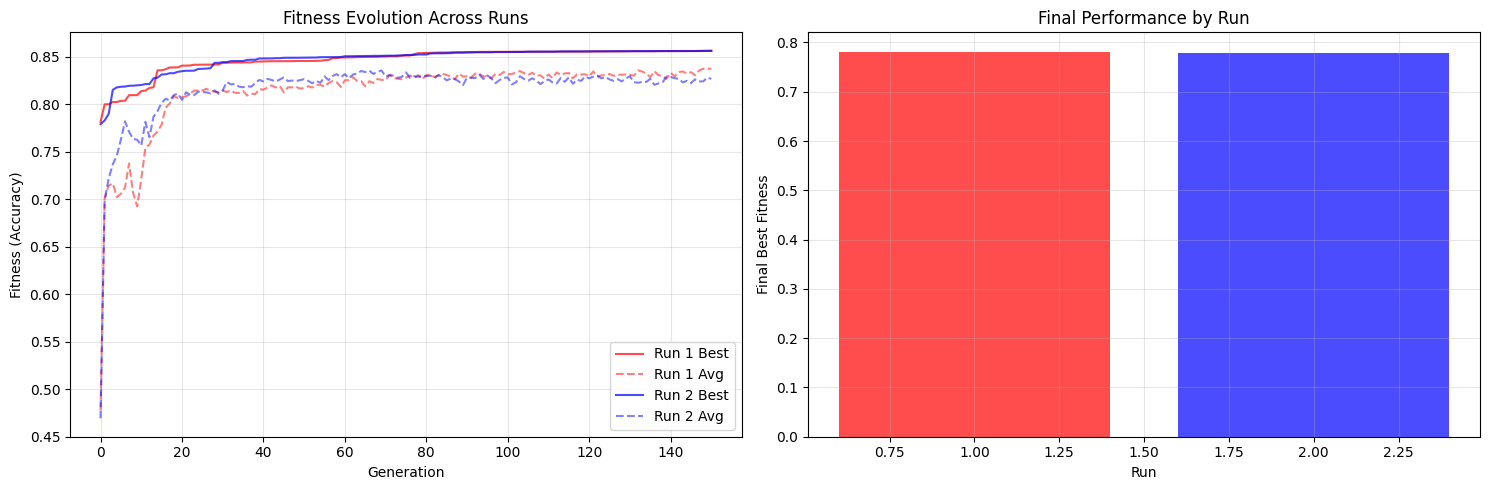

Best Individual Expression:
gt(ARG2, sin(cos(mul(mul(logical_if(logical_if(logical_if(ARG27, add(ARG41, ARG0), ARG29), add(tanh(2.0), ARG0), gt(ARG30, cos(ARG3))), div(sin(ARG3), lt(cos(ARG3), logical_if(ARG27, ARG34, ARG9))), ARG21), ARG14), mul(mul(logical_if(logical_if(ARG14, add(tanh(2.0), ARG0), gt(ARG30, cos(ARG3))), div(sin(ARG3), lt(cos(ARG3), logical_if(2.0, ARG34, ARG9))), abs(ARG5)), ARG14), add(logical_if(gt(ARG30, cos(ARG3)), div(-3.8860942081653924, ARG9), add(cos(ARG38), ARG1)), lt(add(ARG9, sin(add(ARG9, ARG3))), sin(sin(ARG0)))))))))


In [ ]:
# Plot fitness evolution across runs
plt.figure(figsize=(15, 5))

# Fitness plot
plt.subplot(1, 2, 1)
x = np.arange(MAX_GENERATIONS + 1)
colors = ['red', 'blue', 'green']

for run in range(N_RUNS):
    best_accuracies = [fitness[0] for fitness in max_fitness_values[run]]
    avg_accuracies = [fitness[0] for fitness in avg_fitness_values[run]]
    plt.plot(x, best_accuracies, color=colors[run], label=f'Run {run+1} Best', alpha=0.7)
    plt.plot(x, avg_accuracies, color=colors[run], linestyle='--', label=f'Run {run+1} Avg', alpha=0.5)

plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.title('Fitness Evolution Across Runs')
plt.legend()
plt.grid(True, alpha=0.3)

# FInal comparison
plt.subplot(1, 2, 2)
final_fitness = [[fitness[0] for fitness in max_fitness_values[run]][0] for run in range(N_RUNS)]
plt.bar(range(1, N_RUNS + 1), final_fitness, color=colors, alpha=0.7)
plt.xlabel('Run')
plt.ylabel('Final Best Fitness')
plt.title('Final Performance by Run')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best individual
print("Best Individual Expression:")
print(best_individual)

In [ ]:
def create_final_submission(best_individual, X_test, output_file="final_submission.csv"):
    predictions = []

    # I tired both ways, just to be sure. This is more of a safety check
    if hasattr(X_test, 'values'):
        X_test_np = X_test.values
    else:
        X_test_np = X_test

    func = toolbox.compile(expr=best_individual)

    for i, sample in enumerate(X_test_np):
        pred = func(*sample)
        if turnBool(float(pred)):
            predictions.append(1)
        else:
            predictions.append(0)

    # CReate final submission file
    submission = pd.DataFrame({
        'id': range(len(predictions)),
        'income': predictions
    })

    submission.to_csv(output_file, index=False)
    print(f"Predictions: {sum(predictions)} positive out of {len(predictions)}")
    return submission

def turnBool(pred):
    if isinstance(pred, bool):
        return float(pred) > 0.5
    return pred > 0


create_final_submission(best_individual, X_test_processed, "final_submission.csv")

Predictions: 1567 positive out of 9769


,id,income
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
...,...,...
9764,9764,1
9765,9765,0
9766,9766,0
9767,9767,0
